## Step 1: make a list off images to read in 

In [1]:
import os 
import glob
import time
# images are divided up into vehicles and non -vehicles folders 
# First locate vehicle images 
basedir = 'vehicles/'
# Different folders represent different sources for images e.g. GTI, Kitti,
images_types= os.listdir(basedir)
cars = []
for imtype in images_types:
    cars.extend(glob.glob(basedir+imtype+'/*'))
    
print('Number of Vehicle Images found:', len(cars))
with open("cars.txt", 'w') as f:
    for fn in cars:
        f.write(fn+ '\n')

# Do the same thing for nin-vehicle images 
basedir = 'non-vehicles/'
# Different folders represent different sources for images e.g. GTI, Kitti,
images_types= os.listdir(basedir)
notcars = []
for imtype in images_types:
    notcars.extend(glob.glob(basedir+imtype+'/*'))
    
print('Number of Non-Vehicle Images found:', len(cars))
with open("notcars.txt", 'w') as f:
    for fn in cars:
        f.write(fn+ '\n')

Number of Vehicle Images found: 8792
Number of Non-Vehicle Images found: 8792


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel() 
    color2 = cv2.resize(img[:,:,1], size).ravel() 
    color3 = cv2.resize(img[:,:,2], size).ravel() 
    # Return the feature vector
    return np.hstack((color1,color2,color3))

# Define a function to compute color histogram features
# Need to change bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,
                        vis = False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                 hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #test_img = cv2.resize(img[int(window[0][1]):int(window[1][1]), int( window[0][0]): int(window[1][0])], (64, 64))      
    
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dim = len(img.shape)
        if img_dim < 3:
            plt.imshow(img, cmap = 'hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
            

C:\Users\karam\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


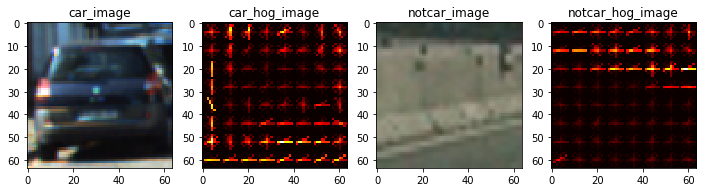

In [25]:
# Choose random car / not-car indices
car_ind = np.random.randint(0,len(cars))
notcar_ind = np.random.randint(0,len(notcars))

# Read in car / not-car images
car_img = mpimg.imread(cars[car_ind])
notcar_img = mpimg.imread(notcars[notcar_ind])

# Define feature parameters
color_space = 'RGB'  # Can be RGB, HSV, LUv, HLS, YUV
orient = 6 
pix_per_cell = 8
cell_per_block= 2
hog_channel = 0 # can be 0, 1, 2, or "ALL"
spatial_size = (16,16) # Spatial binnig diemensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


car_features, car_hog_image = single_img_features(car_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, vis= True)

notcar_features, notcar_hog_image = single_img_features(notcar_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, vis= True)

images = [car_image,car_hog_image,notcar_image,notcar_hog_image]
titles = ['car_image','car_hog_image','notcar_image','notcar_hog_image']
fig = plt.figure(figsize=(12,3))
visualize(fig,1,4,images,titles)

## Start to train a classifier
Try which Features will give us the best results

### First test:
RGB Color space HOG only for the first channel

In [9]:
# Define feature parameters
color_space = 'RGB'  # Can be RGB, HSV, LUv, HLS, YUV
orient = 6
pix_per_cell = 8
cell_per_block= 2
hog_channel = 'ALL' # can be 0, 1, 2, or "ALL"
spatial_size = (16,16) # Spatial binnig diemensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t = time.time()
n_samples = 1000 # for more as 1000 samples need a lot of time
random_idxs = np.random.randint(0,len(cars), n_samples)
test_cars = np.array(cars)[random_idxs]
test_notcars = np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t,'Seconds to compute thefeatures...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector, one to all the car features 
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient, 'orientations', pix_per_cell,
    'pixels per cell', cell_per_block,'cells per block',
     hist_bins, 'histogram bins, and', spatial_size, 'spatial sampling')
print('Feature vector length:', len(X_train[0]))


# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

C:\Users\karam\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


15.8279390335083 Seconds to compute thefeatures...
Using: 6 orientations 8 pixels per cell 2 cells per block 16 histogram bins, and (16, 16) spatial sampling
Feature vector length: 4344
5.07 Seconds to train SVC...
Test Accuracy of SVC =  0.985


### First test:
RGB Color space HOG only for the first channe

In [10]:
# Define feature parameters
color_space = 'YCrCb'  # Can be RGB, HSV, LUv, HLS, YUV
orient = 9
pix_per_cell = 8
cell_per_block= 2
hog_channel = 'ALL' # can be 0, 1, 2, or "ALL"
spatial_size = (16,16) # Spatial binnig diemensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t = time.time()
n_samples = 1000 # for more as 1000 samples need a lot of time
random_idxs = np.random.randint(0,len(cars), n_samples)
test_cars = np.array(cars)[random_idxs]
test_notcars = np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t,'Seconds to compute thefeatures...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector, one to all the car features 
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient, 'orientations', pix_per_cell,
    'pixels per cell', cell_per_block,'cells per block',
     hist_bins, 'histogram bins, and', spatial_size, 'spatial sampling')
print('Feature vector length:', len(X_train[0]))


# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

C:\Users\karam\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


14.31896686553955 Seconds to compute thefeatures...
Using: 9 orientations 8 pixels per cell 2 cells per block 16 histogram bins, and (16, 16) spatial sampling
Feature vector length: 6108
7.55 Seconds to train SVC...
Test Accuracy of SVC =  0.99


## Train on the hole data set

In [4]:
# Define feature parameters
color_space = 'YCrCb'  # Can be RGB, HSV, LUv, HLS, YUV
orient = 9
pix_per_cell = 8
cell_per_block= 2
hog_channel = 'ALL' # can be 0, 1, 2, or "ALL"
spatial_size = (16,16) # Spatial binnig diemensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t = time.time()
n_samples = 1000 # for more as 1000 samples need a lot of time
test_cars = cars
test_notcars = notcars

car_features = extract_features(test_cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t,'Seconds to compute thefeatures...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector, one to all the car features 
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient, 'orientations', pix_per_cell,
    'pixels per cell', cell_per_block,'cells per block',
     hist_bins, 'histogram bins, and', spatial_size, 'spatial sampling')
print('Feature vector length:', len(X_train[0]))


# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

C:\Users\karam\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


96.28860449790955 Seconds to compute thefeatures...
Using: 9 orientations 8 pixels per cell 2 cells per block 16 histogram bins, and (16, 16) spatial sampling
Feature vector length: 6108
5.58 Seconds to train SVC...
Test Accuracy of SVC =  0.9904


## Test the calssifier:
We can now test the classifier on some examples 

In [27]:
imagespath = './test_images/*'
example_images = glob.glob(imagespath)
images = []
titles = []

# Min and may in y to search in slide_window()
y_start_stop = [None,None] # Don't define the range of interisting y
overlap = 0.5

for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_image = np.copy(img)
    img = img.astype(np.float32)/255
    print(np.min(img), np.max(img))
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(overlap, overlap))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                                 spatial_size=spatial_size, hist_bins=hist_bins, 
                                 orient=orient, pix_per_cell=pix_per_cell, 
                                 cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                 hist_feat=hist_feat, hog_feat=hog_feat)                       
    
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)        
    images.append(window_img)
    titles.append(' ')
    print(time.time()-t1, 'seconds to process one image searching', len(windows), 'windows')



0.0 1.0


C:\Users\karam\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1.2345027923583984 seconds to process one image searching 190 windows
0.0 1.0
1.676464319229126 seconds to process one image searching 190 windows
0.0 1.0
1.523378610610962 seconds to process one image searching 190 windows
0.0 1.0
2.1515307426452637 seconds to process one image searching 190 windows
0.0 1.0
1.6278996467590332 seconds to process one image searching 190 windows
0.0 1.0
1.5052769184112549 seconds to process one image searching 190 windows


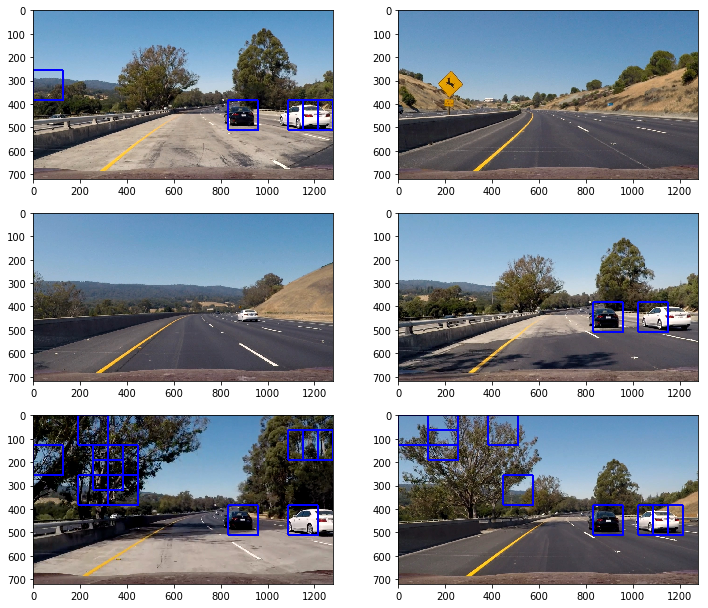

In [56]:
fig = plt.figure(figsize = (12,18))
visualize(fig, 5, 2 , images, titles)

There ary many boxes and the easiest way to handlle this problem is to restrect the part of image. 

In [57]:
imagespath = './test_images/*'
example_images = glob.glob(imagespath)
images = []
titles = []

# Min and may in y to search in slide_window()
y_start_stop = [400,655] # Don't define the range of interisting y
overlap = 0.5

for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_image = np.copy(img)
    img = img.astype(np.float32)/255
    print(np.min(img), np.max(img))
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(overlap, overlap))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                                 spatial_size=spatial_size, hist_bins=hist_bins, 
                                 orient=orient, pix_per_cell=pix_per_cell, 
                                 cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                 hist_feat=hist_feat, hog_feat=hog_feat)                       
    
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)        
    images.append(window_img)
    titles.append(' ')
    print(time.time()-t1, 'seconds to process one image searching', len(windows), 'windows')



0.0 1.0


C:\Users\karam\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.43030667304992676 seconds to process one image searching 38 windows
0.0 1.0
0.29120731353759766 seconds to process one image searching 38 windows
0.0 1.0
0.32022857666015625 seconds to process one image searching 38 windows
0.0 1.0
0.32222843170166016 seconds to process one image searching 38 windows
0.0 1.0
0.27219343185424805 seconds to process one image searching 38 windows
0.0 1.0
0.5413899421691895 seconds to process one image searching 38 windows


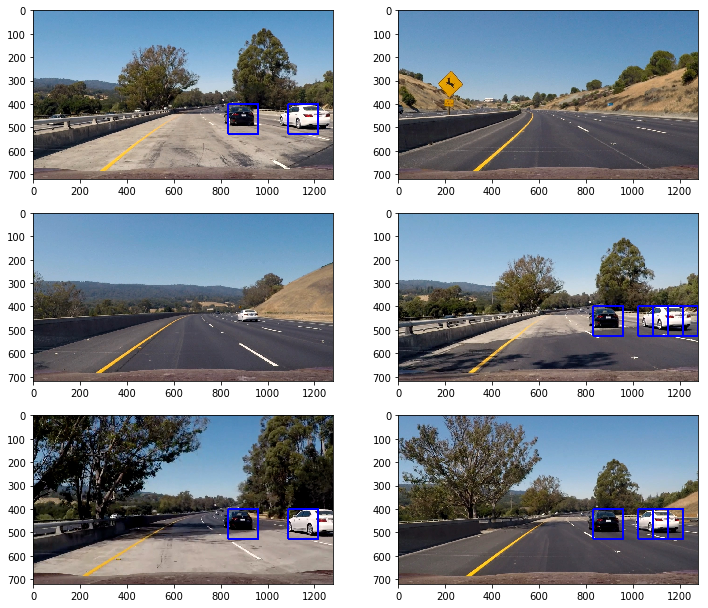

In [58]:
fig = plt.figure(figsize = (12,18))
visualize(fig, 5, 2 , images, titles)

In [61]:
imagespath = './test_images/*'
example_images = glob.glob(imagespath)
images = []
titles = []

# Min and may in y to search in slide_window()
y_start_stop = [400,655] # Don't define the range of interisting y
overlap = 0.5

for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_image = np.copy(img)
    img = img.astype(np.float32)/255
    print(np.min(img), np.max(img))
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(overlap, overlap))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                                 spatial_size=spatial_size, hist_bins=hist_bins, 
                                 orient=orient, pix_per_cell=pix_per_cell, 
                                 cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                 hist_feat=hist_feat, hog_feat=hog_feat)                       
    
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)        
    images.append(window_img)
    titles.append(' ')
    print(time.time()-t1, 'seconds to process one image searching', len(windows), 'windows')



0.0 1.0


C:\Users\karam\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.8811278343200684 seconds to process one image searching 100 windows
0.0 1.0
1.0217294692993164 seconds to process one image searching 100 windows
0.0 1.0
0.793562650680542 seconds to process one image searching 100 windows
0.0 1.0
0.7830564975738525 seconds to process one image searching 100 windows
0.0 1.0
0.8355965614318848 seconds to process one image searching 100 windows
0.0 1.0
0.7915616035461426 seconds to process one image searching 100 windows


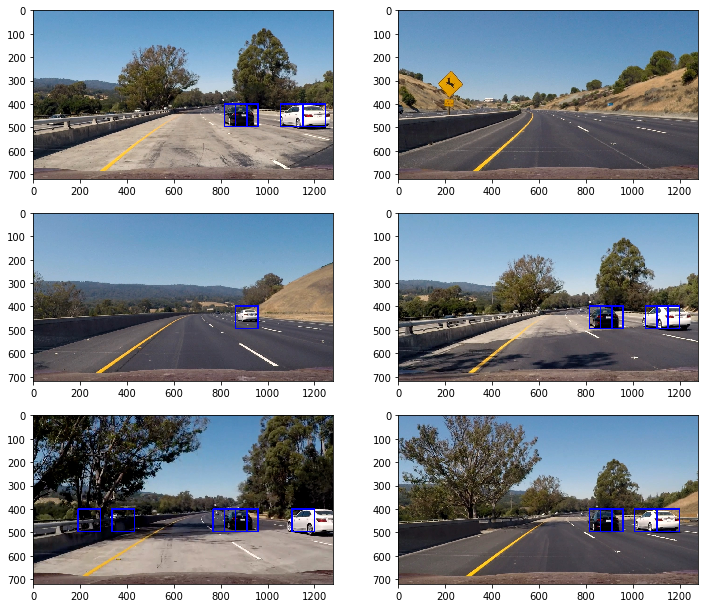

In [62]:
fig = plt.figure(figsize = (12,18))
visualize(fig, 5, 2 , images, titles)

It is nice to have your search windows be integeer multipkles of your cell size of hoge because as you noticed we are still moving really slow we are searching just a hunderd windows in a second.

Take the hog features for the entire image once and then sampling that array to extract features to each window

In [5]:
def convert_color(img, conv = 'RGB2YCrCB'):
    if conv == 'RGB2YCrCB':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCB':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [6]:
imagespath = './test_images/*'
example_images = glob.glob(imagespath)


out_images = []
out_maps = []
out_titles = []
out_boxes = []

# Consider a narrower swatch in y 
ystart = 400
ystop = 655
scale = 1.5 # we use it to search by using different windows sizes 

# iterte over test images 
for img_src in example_images:
    img_boxes = []
    t1 = time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)    
    
    # Make a heat map of zeros
    heatmap =  np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    # Convert its colors
    ctrans_tosearch = convert_color(img_tosearch, conv = 'RGB2YCrCB')
    
    # we need to use different scale recctangel but there is another solution namly change the size of the image
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1  ## Hold the numberr of hog cell across the image 
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1 ## // we use this version of deivision because we want the result be int
    nfeat_per_block = orient*cell_per_block**2      ## the number of features per block
    
    window = 64
    nblocks_per_window =  ( window // pix_per_cell) - 1
    cells_per_step = 2  # instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step  #how many steps we make along the hog array to extract features
    nysteps = (nyblocks- nblocks_per_window)  // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count +=1 
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)) 
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract  the image patch to do spatial features an histogram features 
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1: # plot box and add heat to heatmap
                xbox_left = np.int(xleft*scale) # sclae of the image
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart: ytop_draw+ win_draw + ystart, xbox_left: xbox_left + win_draw] += 1
                
    print(time.time()-t, 'seconds to run, total windows = ',count)
    
    out_images.append(draw_img)
    
    out_titles.append(img_src[-12:])
    out_titles.append(img_src[-12:])
    
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)            

C:\Users\karam\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


41.180482625961304 seconds to run, total windows =  294
41.80702805519104 seconds to run, total windows =  294
42.35167574882507 seconds to run, total windows =  294
42.82369518280029 seconds to run, total windows =  294
43.260231256484985 seconds to run, total windows =  294
43.72391676902771 seconds to run, total windows =  294


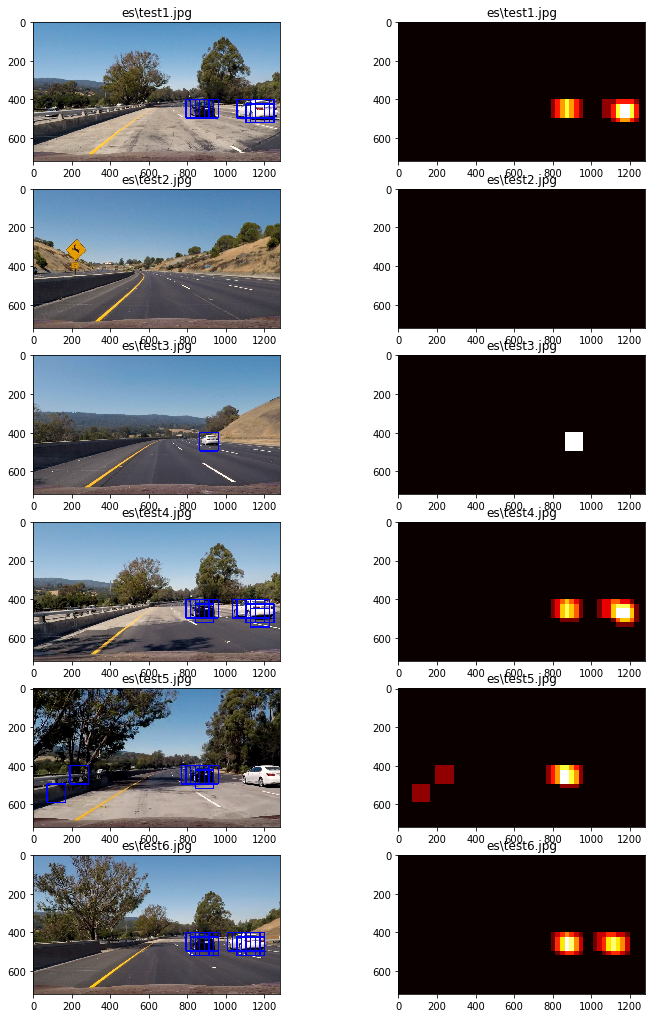

In [7]:
fig = plt.figure(figsize = (12,24))
visualize(fig, 8, 2, out_images ,out_titles)

In [14]:
def find_cars(img, scale):
    # make a copy of image to drow the recatngels on it
    draw_img = np.copy(img)   
    # Make a heat map of zeros
    heatmap =  np.zeros_like(img[:,:,0])
    # Normalize the image 
    img = img.astype(np.float32)/255
    # take the desired part of the image 
    img_tosearch = img[ystart:ystop,:,:]

    # Convert its color
    ctrans_tosearch = convert_color(img_tosearch, conv = 'RGB2YCrCB')
    
     # we need to use different scale recctangel but there is another solution namly change the size of the image
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1  ## Hold the numberr of hog cell across the image 
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1 ## // we use this version of deivision because we want the result be int
    nfeat_per_block = orient*cell_per_block**2      ## the number of features per block
    
    window = 64
    nblocks_per_window =  ( window // pix_per_cell) - 1
   
    cells_per_step = 2  # instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step  #how many steps we make along the hog array to extract features
    nysteps = (nyblocks- nblocks_per_window)  // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)) 
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract  the image patch to do spatial features an histogram features 
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1: # plot box and add heat to heatmap
                xbox_left = np.int(xleft*scale) # sclae of the image
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart: ytop_draw+ win_draw + ystart, xbox_left: xbox_left + win_draw] += 1
                
    return draw_img, heatmap            

We can use the heatmap to detect the overalpping

In [9]:
from scipy.ndimage.measurements import label 

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold 
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detetected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car number lebel value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])  
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y vlaues 
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image 
        cv2.rectangle(img, bbox[0], bbox[1],(0,0,255), 6)
    # Return the image
    return img

C:\Users\karam\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


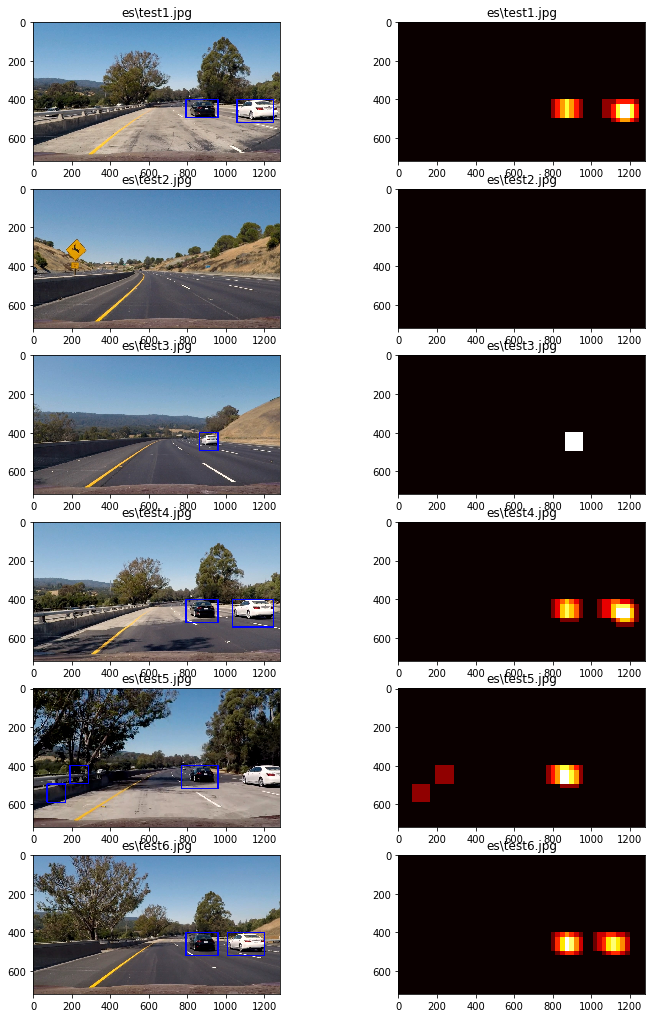

In [10]:
out_images = []
out_maps = []
ystart = 400
ystop = 655
scale = 1.5

# iterte over test images 
for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img, heat_map = find_cars(img,scale)
    heat_map = apply_threshold(heat_map, 0.95)
    labels = label(heat_map)
    # Draw the bounding boxes on a copy of the image 
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)  
    out_images.append(draw_img)
    out_images.append(heat_map)

fig = plt.figure(figsize =(12,24))
visualize(fig, 8 ,2, out_images, out_titles)

## Video:

In [22]:
def process_image(img):
    out_img, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

def clear_cache():
    process_image.cache = None

In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
in_clip = VideoFileClip("project_video.mp4")
vid_output = 'project_output2.mp4'

In [26]:
out_clip = in_clip.fl_image(process_image)
%time  out_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video project_output2.mp4
[MoviePy] Writing video project_output2.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [09:59<00:00,  2.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output2.mp4 

Wall time: 10min


In [20]:
HTML("""
<video width= "960" height= "540" controls>
   <source src="{0}">
</video>
""".format("test_output.mp4"))

In [65]:
np.max(heat_map)

7

Define a class to receive the characteristics of each vehilce detection
object defiend as " Vehicles " will be where multiple overlapping detection exist i